In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import numpy as np
import torch
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import  torch.nn as nn
import torch.nn.functional as F
rseed = 42
np.random.seed(rseed)
torch.manual_seed(rseed)
gpu_id = '2'
from joblib import Parallel, delayed
os.environ['CUDA_VISIBLE_DEVICES']=gpu_id
os.environ['JOBLIB_TEMP_FOLDER'] = '/ksozykinraid/data/tmp/'
from time import time
import torch 
import pandas as pd
import glob2
import json
from tqdm import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from utils import *
from datasets import *
from layers import *

## Datasets

In [3]:
data_root = '/ksozykinraid/data/sensors/'
data_fnzip =  "%s/%s" % (data_root , 'PAMAP2_Dataset.zip')
data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip'

In [4]:
if not os.path.exists(data_fnzip[:-4]):
    !curl -L $data_url -o $data_fnzip
    !unzip $data_fnzip -d $data_root

In [5]:
path2subjets = sorted(glob2.glob('%s/PAMAP2_Dataset/Protocol/*.dat' % data_root))

In [6]:
def pamap_columns():
    """
        https://github.com/NLeSC/mcfly-tutorial/blob/master/utils/tutorial_pamap2.py
    """
    axes = ['x', 'y', 'z']
    IMUsensor_columns = ['temperature'] + \
        ['acc_16g_' + i for i in axes] + \
        ['acc_6g_' + i for i in axes] + \
        ['gyroscope_' + i for i in axes] + \
        ['magnometer_' + i for i in axes] + \
        ['orientation_' + str(i) for i in range(4)]
    columns = ["timestamp", "activityID", "heartrate"] + ["hand_" + s
                                                         for s in IMUsensor_columns] \
        + ["chest_" + s for s in IMUsensor_columns] + ["ankle_" + s
                                                       for s in IMUsensor_columns]
    return columns

In [7]:
demo_activities = "lying,sitting,standing,walking".split(',')

In [8]:
all_columns = pamap_columns()

In [9]:
input_channels = len(data_columns)

In [10]:
input_channels

27

In [11]:
# np.min([len(s) for s in subjects])
min_len = 93620

In [12]:
demo_mode = True

In [13]:
subjects = []
n_subjects = len(path2subjets)
for i in tqdm(range(n_subjects)):
    subject = pd.read_csv(path2subjets[i],header=None,sep=' ')
    subject.columns = pamap_columns()
    if demo_mode:
        subject = subject[subject['activityID'].isin([label2num[a] for a in demo_activities])]
        subject['activityID'] = subject['activityID'] - 1
    subject = subject[useful_columns]
    if len(subject) > 0:
        subject = subject.fillna(0)
        #subject = subject.iloc[:min_len]
        subjects.append(subject)

100%|██████████| 9/9 [00:18<00:00,  2.09s/it]


In [14]:
subjects[4].head()

,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_gyroscope_x,hand_gyroscope_y,hand_gyroscope_z,hand_magnometer_x,hand_magnometer_y,hand_magnometer_z,chest_acc_16g_x,...,ankle_acc_16g_x,ankle_acc_16g_y,ankle_acc_16g_z,ankle_gyroscope_x,ankle_gyroscope_y,ankle_gyroscope_z,ankle_magnometer_x,ankle_magnometer_y,ankle_magnometer_z,activityID
9880,-9.00214,3.10187,2.31949,-0.146257,-0.059699,-0.051229,49.9839,13.3515,-7.36445,0.837079,...,9.71683,0.336921,-2.38836,0.014686,0.019172,0.017190,-38.2428,-49.3220,12.2520,0
9881,-8.77219,3.17667,2.39966,-0.130033,-0.024626,-0.093336,50.3520,13.4562,-6.97214,0.987250,...,9.64108,0.375685,-2.42796,-0.004786,-0.003672,0.019288,-37.9971,-48.9484,12.1106,0
9882,-9.11203,3.02787,2.43356,-0.093558,-0.097161,-0.078489,49.9861,13.3512,-7.62692,0.796677,...,9.71204,0.262269,-2.54230,-0.025297,0.020647,0.021037,-38.7444,-49.2944,13.1012,0
9883,-8.95953,3.02704,2.47433,-0.127502,-0.062408,-0.070290,50.6001,13.5670,-7.10454,1.019650,...,9.75036,0.223742,-2.50308,-0.039941,0.018389,-0.008956,-38.6244,-49.3025,12.3925,0
9884,-8.95847,3.17880,2.47383,-0.122835,-0.056185,-0.060001,50.6028,13.6906,-7.63023,1.013930,...,9.64009,0.185842,-2.42680,0.015034,0.031196,0.003912,-37.9932,-48.6886,12.9613,0


In [15]:
label2num.keys()

dict_keys(['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic walking', 'watching TV', 'computer work', 'car driving', 'ascending stairs', 'descending stairs', 'vacuum cleaning', 'ironing', 'folding laundry', 'house cleaning', 'playing soccer', 'rope jumping', 'other'])

In [16]:
if demo_mode:
    num_classes = 4
else:
    num_classes = max([int(e) for e in num2label.keys() ]) + 1

In [17]:
num_classes

4

In [18]:
win_size = 256
step = 128

In [19]:
train_dataset = pamap2Dataset(subjects,evaluate=False,win_size=win_size,step=step,num_classes=num_classes)
val_dataset = pamap2Dataset(subjects,evaluate=True,num_classes=num_classes)


100%|██████████| 8/8 [00:04<00:00,  1.60it/s]


In [20]:
train_lb = np.argmax(train_dataset.labels[train_dataset.train_idxs],-1)
val_lb = np.argmax(val_dataset.labels[val_dataset.val_idxs],-1)

(array([ 997.,    0.,    0., 1035.,    0.,    0., 1293.,    0.,    0.,
        1076.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

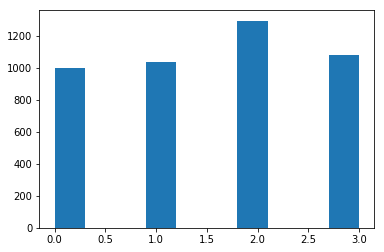

In [21]:
plt.hist(train_lb)

(array([448.,   0.,   0., 449.,   0.,   0., 564.,   0.,   0., 426.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

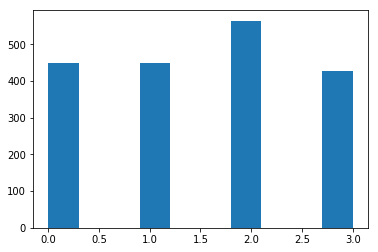

In [22]:
plt.hist(val_lb)

# Models

In [23]:
class Conv1DNet(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv11 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(256*(win_size//(2**3)),512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.conv11,self.pool11,
             nn.ReLU(),                            
             self.conv21,self.pool21,
             nn.ReLU(),
             self.conv31,self.pool31,
             nn.ReLU(),
             Flatten(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.ReLU(),
             self.fc2,
             nn.ReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input)
        return self.classifier(features)

In [24]:
class MultiSincNet(nn.Module):
    
    def __init__(self,
                 N_filt = 12,  
                 Filt_dim = 5, 
                 fs = 100,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.fs = fs
        self.device = device
        self.sincconv = multichannel_sinc_conv(Filt_dim=Filt_dim,
                                  N_channels=input_channels,
                                  N_filt=N_filt,
                                  fs=fs,
                                  device = device)
        self.layer_norm = LayerNorm(win_size-Filt_dim+1)
        self.conv11 = nn.Conv1d(in_channels=324, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(7936,512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.sincconv,
             #self.layer_norm,
             self.conv11,
             nn.LeakyReLU(),
             self.pool11,
             nn.LeakyReLU(),                            
             self.conv21,self.pool21,
             nn.LeakyReLU(),
             self.conv31,self.pool31,
             nn.LeakyReLU(),
             Flatten(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.LeakyReLU(),
             self.fc2,
             nn.LeakyReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input)
        return self.classifier(features)

In [25]:
#debug
device = 'cpu'
batch_size = 1
model = MultiSincNet(device=device).to(device)
dummy_batch = train_dataset.data[:batch_size]
dummy_batch = torch.tensor(dummy_batch).transpose(2,1)
prediction = model(dummy_batch.to(device))
del model
del dummy_batch
print(prediction.shape)
del prediction
torch.cuda.empty_cache()

torch.Size([1, 4])


## Experiments

In [26]:
num_epochs = 20
verbose = 5
batch_size = 1024
device = "cuda"

In [27]:

def compute_loss(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    reference = torch.argmax(reference,dim=-1).to(torch.long)
    prediction = prediction.log_softmax(dim=-1)
    loss = nn.NLLLoss()(prediction,reference)
    return loss

In [28]:
def compute_acc(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    prediction = torch.argmax(prediction.log_softmax(dim=-1),dim=-1)
    reference = torch.argmax(reference,dim=-1)
    return (reference == prediction).to(torch.float32).mean()

In [29]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

In [30]:
model = Conv1DNet().to(device)
#model = MultiSincNet(device=device).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)

In [31]:
best_acc = -1
best_loss =999999999
sPATH = ''
fmt_str = '/ksozykinraid/har-models/%s_%dclass_%.4f.pth'

In [32]:
from collections import  defaultdict
report  = defaultdict(list)

In [33]:
from IPython import display

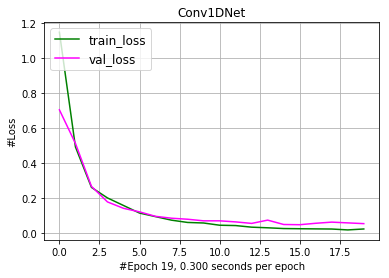

19	Training:
	Loss:	0.02415
	ACC:	0.99114
19	Validation:
	BEST VAL loss:	0.04846
	Loss:	0.05459
	ACC:	0.98357




In [34]:

for epoch in range(num_epochs):
    
    
    train_loss = train_acc = train_batches = 0 
    train_acc_fixed = 0
    model.train()
    y_true,y_pred = [],[]
    start = time.time()
    for batch in train_loader:
        
        data,reference = batch
        data = data.transpose(2,1).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        with torch.no_grad():
            train_loss += loss.item()
            train_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    
    with torch.no_grad():
        train_acc += compute_acc(y_true, y_pred).cpu().numpy()
    
    val_loss = val_acc = val_batches = 0
    val_acc_fixed = 0
    #model.train(False)
    model.eval()
    y_true,y_pred = [],[]
    for batch in val_loader:
        data,reference = batch
        data = data.transpose(2,1).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        with torch.no_grad():
            val_loss += loss.item()
            
            val_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    with torch.no_grad():
        val_acc += compute_acc(y_true, y_pred).cpu().numpy()
    #val_acc = (val_acc / val_batches)
    
    val_loss = (val_loss / val_batches)
    if val_loss < best_loss:
        best_loss = val_loss
        if sPATH != '' and os.path.exists(sPATH):
            os.remove(sPATH)
        sPATH = fmt_str % (model.__class__.__name__,num_classes,best_loss)
        torch.save(model.state_dict(),sPATH)
        if best_acc > 94:
            print("Early Stopping")
            break
    report['train_loss'].append(train_loss / train_batches)
    report['val_loss'].append(val_loss)
    finish = time.time()
    time_epoch = finish-start    
    display.clear_output(wait=True)
    fig = plt.Figure(figsize=(12,6),facecolor='white')
    plt.plot(report['train_loss'],color='green',label='train_loss')
    plt.plot(report['val_loss'],color='magenta',label='val_loss')
    plt.xlabel("#Epoch %d, %.3f seconds per epoch" % (epoch,time_epoch))
    plt.ylabel("#Loss")
    plt.title(model.__class__.__name__)
    legend(loc=2, prop={'size': 12})
    plt.grid()
    plt.show()
    
    print("%d\tTraining:" % (epoch))
        
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tACC:\t%.5f" % (train_acc))
    print("%d\tValidation:" % (epoch))
    print("\tBEST VAL loss:\t%.5f" % best_loss)
    print("\tLoss:\t%.5f" % val_loss)
    print("\tACC:\t%.5f" % val_acc)
    print('\n')
    
    
    if epoch  % verbose == 0 or epoch == num_epochs - 1:
        pass

In [35]:
model.load_state_dict(torch.load(sPATH))
model.eval();

## Metrics

In [36]:
y_true_np = torch.argmax(y_true,dim=-1).detach().cpu().numpy()
y_pred_np = torch.argmax(y_pred.log_softmax(dim=-1),dim=-1).detach().cpu().numpy()

In [37]:
n_conf = 5 if demo_mode else num_classes + 1

In [38]:
if demo_mode:
    y_true_np,y_pred_np = y_true_np+1,y_pred_np+1 

In [39]:
creport = pd.DataFrame((classification_report(y_true_np,y_pred_np,output_dict=True)))

fm_score = []
for i in range(n_conf):
    try:
        fm_score.append(creport[str(i)]['f1-score'])
    except:
        pass

In [40]:
np.mean(fm_score )

0.9834317458343345

In [41]:
n_conf

5

In [42]:
# rope jumping corrupting color scheme
cm  = create_conf_matrix(y_true_np,y_pred_np,n_classes=n_conf)
cmdf = pd.DataFrame(cm)

cols = [num2label[i] if i in list(num2label.keys()) else str(i) for i in range(n_conf)]
cmdf.columns = cols
cmdf.index = cols
correct = [i for i,e in enumerate(cmdf.columns) if not str(e).isnumeric() ]
cmdf = cmdf.iloc[correct ,correct ]
#if 'rope jumping' in cmdf.columns:
#    cmdf = cmdf.drop('rope jumping', 1)

In [43]:
print(model.__class__)

<class '__main__.Conv1DNet'>


In [44]:
cmdf

,other,lying,sitting,standing,walking
other,0,0,0,0,0
lying,0,436,6,7,2
sitting,0,11,443,4,0
standing,0,1,0,553,0
walking,0,0,0,0,424


## History of best Results

#### Regular conv1DNet
all classes F_m : 0.9021275746051783
<br>
4 classes F_M   : 0.9834350989829983

#### MultiSincNet
all classes F_m : 0.916053014748477
<br>
4 classes F_M   : 0.9863380805083194